# Определение возраста покупателей

## Описание проекта

### Цель проекта

Заказчиком проекта является сетевой супермаркет «Хлеб-Соль», который внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
* Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
* Контролировать добросовестность кассиров при продаже алкоголя.

Целью работы является построение модели нейронной сети, которая по фотографии определит приблизительный возраст человека. Значение метрики MAE построенной модели на тестовой выборке должно быть не больше 8.

В качестве исходных данных будет использован набор фотографий людей с указанием возраста.

### План проекта

Сначала будет выполнен исследовательский анализ набора фотографий.

Далее модель будет подготовлена и обучена на сервере с графической картой Yandex Compute Cloud.

## Исследовательский анализ данных

### Импорт библиотек

In [1]:
import os

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import numpy as np

import pandas as pd

from PIL import Image
import pylab as pl

import random

### Загрузка данных

Для обучения модели все изображения переводятся в векторный вид. Векторный представление изображения - это трёхмерный массив, в ячейках которых содержатся целые числа от 0 до 255.

Тренировочный датасет - это четырёхмерный массив данных. Загрузка всего этого массива в проект требует огромного ресурса оперативной памяти, которой нет у обычных персональных компьютеров.

Поэтому для загрузки исходных данных в проект будет использована динамическая загрузка данных с помощью загрузчика *ImageDataGenerator* из библиотеки *Keras*. Зададим размер батча 32. Картинки будут приведены к единому размеру 224х224.

Изображения размещены в директории '...'. В csv-файле приведены названия файлов и целевой признак - возраст людей.

In [2]:
# creating dataset with age values and file names
labels = pd.read_csv('...')

# creatinf generator
train_datagen = ImageDataGenerator(rescale=1./255)

# extracting data
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='...',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


В папке с исходными данными идентифицировано 7591 изображений.

Выведем на экран данные по таблице с целевым признаком.

In [3]:
# getting common info
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


В таблице - 7591 объектов, совпадает с количеством изображений.

Выведем на экран верхние строки таблицы.

In [4]:
# viewing the top rows
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


Изображения сохранены в формате jpeg.

Посмотрим на распределение возраста.

In [5]:
# getting description
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


Оценим общий объём фотографий.

In [6]:
data_volume = 0
directory = '...'
for path, dirs, files in os.walk(directory):
    for f in files:
        fp = os.path.join(path, f)
        data_volume += os.path.getsize(fp)
print('Общий объём фотографий составляет', round(data_volume / 1024**2), 'Мб.')

Общий объём фотографий составляет 237 Мб.


Построим гистограмму распределения возраста людей.

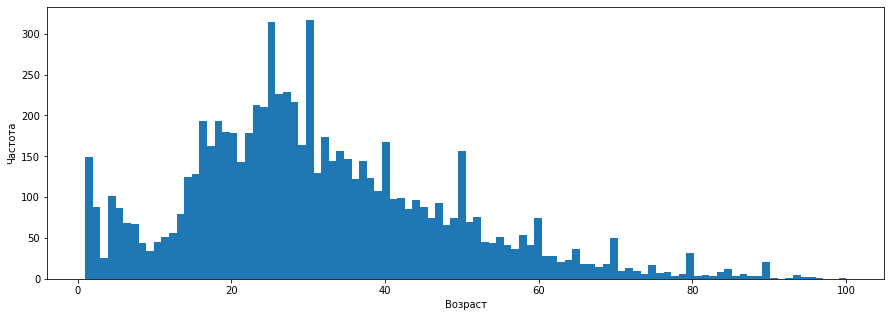

In [7]:
# building a histogram with age values
labels['real_age'].plot(kind='hist', bins=100, figsize=(15,5));

# naming axes
pl.xlabel('Возраст');
pl.ylabel('Частота');

На графике наблюдаются пики для возрастов 1, 25, 30, 40, 50, 60, 70, 80, 90. Скорее всего некоторые возрасты при разметке были округлены до ближайшего десятка.

Выведем на экран несколько фотографий.

Для этого создадим набор признаков.

In [8]:
# creating features 
x,y = train_gen_flow.next()

# getting shape of sample
x.shape

(32, 224, 224, 3)

Создадим произвольный список из 12 значений с целыми числами от 0 до 31, по размеру батча.

In [9]:
np.random.seed(1534)
indexes = np.arange(31)
np.random.shuffle(indexes)
indexes[:12]

array([29, 12, 24, 17, 18,  4, 27,  7, 14, 15, 10,  3])

Выведем на экран изображения с индексами из сформированного списка `indexes`.

На каждой фотографии подпишем возраст человека.

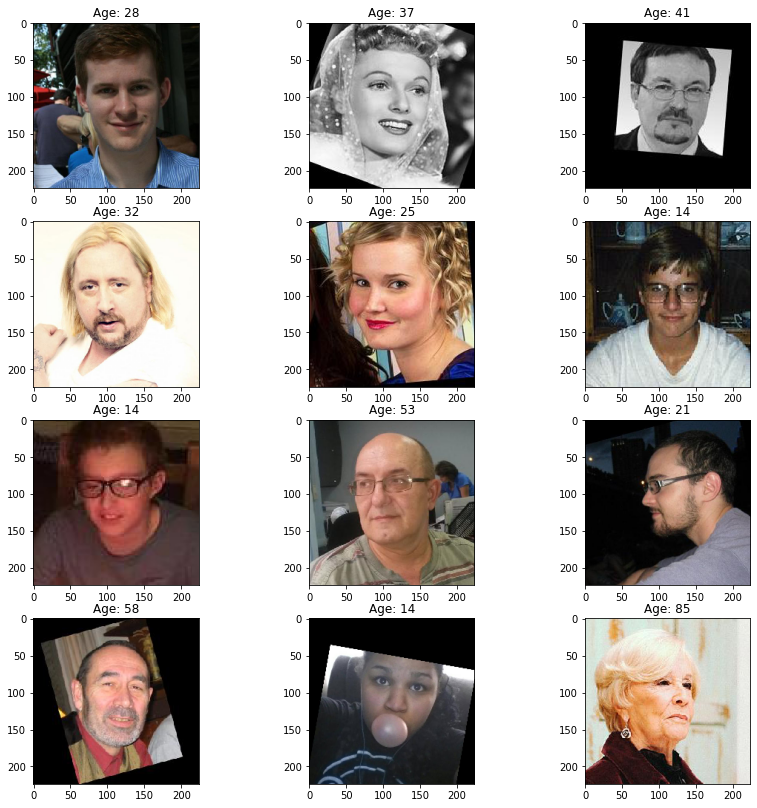

In [10]:
pic_box=plt.figure(figsize=(14,14))

for i in range(12):
    pic_box.add_subplot(4,3,i+1)
    title = y[indexes[i]]
    plt.imshow(x[indexes[i]]);
    plt.title(f'Age: {title}')
    
plt.show()

Дополнительно проверим фотографии детей возрастом 1 год.

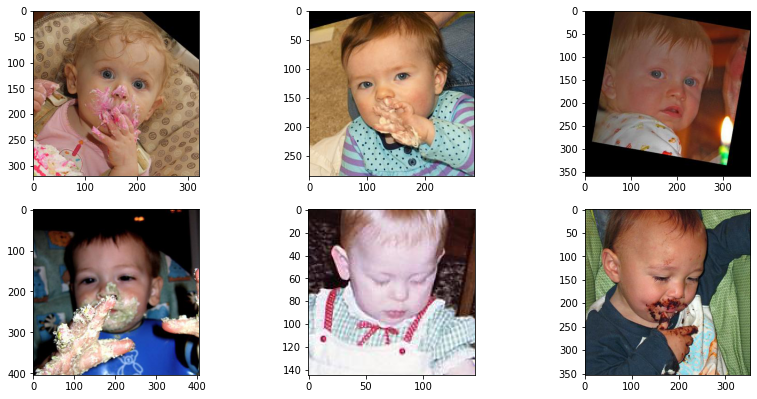

In [11]:
childs = labels[labels['real_age']<2].head(6)['file_name'].tolist()

pic_box=plt.figure(figsize=(14,14))

for i in range(len(childs)):
    pic_box.add_subplot(4,3,i+1)
    plt.imshow(mpimg.imread(directory + childs[i]));
    
plt.show()

### Вывод

Исходные данные представляют собой набор из 7591 изображений и таблицы, сопоставляющей названия файлов и возраст людей, изображённых на картинках. Общий объём фотографий - 237 Мб.

Наибольшее количество фотографий приведены для людей среднего возраста, всего приведено фотографий для людей от 1 года до 100 лет. На гистограмме распределения возрастов наблюдаются пики для возрастов 1, 25, 30, 40, 50, 60, 70, 80, 90. Это может говорить о том, что некоторые возрасты при разметке были округлены до ближайшего десятка..

Визуальный анализ выведенных на экран фотографий подтвердил адекватность данных: возраст людей, изображённых на фотографиях, вполне реальный.

Имеющийся объём исходных данных может быть достаточен для обучения модели. Перед обучением нужно будет искусственно увеличить выборку путём аугментации.

Переходим к обучению модели.

## Обучение модели

Для решения задачи построена модель архитектуры свёрточной нейронной сети ResNet с 50 слоями из библиотеки *Keras*.

Обучение модели выполнено на сервере с графической картой Yandex Compute Cloud.

В данном разделе будет приведён код обучения модели и её результат вывода на экран.

**Код обучения модели на сервере с графической картой.**

```python

from tensorflow.keras import Sequential
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import pandas as pd

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25, 
                                       rescale=1./255, 
                                       horizontal_flip=True, 
                                       rotation_range=20, 
                                       width_shift_range=0.1, 
                                       height_shift_range=0.1, 
                                       zoom_range=.1)
    datagen_flow_train = train_datagen.flow_from_dataframe(dataframe=labels, 
                                                           directory=path + '/final_files', 
                                                           x_col='file_name', y_col='real_age', 
                                                           target_size=(224, 224), 
                                                           batch_size=32, 
                                                           class_mode='raw', 
                                                           seed=12345, 
                                                           subset='training')
    return datagen_flow_train

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    datagen_flow_test = test_datagen.flow_from_dataframe(dataframe=labels, 
                                                         directory=path + '/final_files', 
                                                         x_col='file_name', 
                                                         y_col='real_age', 
                                                         target_size=(224, 224), 
                                                         batch_size=32, 
                                                         class_mode='raw', 
                                                         seed=12345, 
                                                         subset='validation')
    return datagen_flow_test

def create_model(input_shape):
    backbone = ResNet50(input_shape=(224, 224, 3), weights='imagenet', include_top=False)
    optimizer = Adam(lr=0.0001)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=1, activation='relu'))
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mean_absolute_error'])
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=7, steps_per_epoch=None, validation_steps=None):
    
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
        
    model.fit(train_data, 
              validation_data=test_data, 
              batch_size=batch_size, 
              epochs=epochs, 
              steps_per_epoch=steps_per_epoch, 
              validation_steps=validation_steps, 
              verbose=2, 
              shuffle=True)
    
    return model

```

**Результат работы кода.**

```

2022-10-24 07:04:33.991076: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6
2022-10-24 07:04:34.198064: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6
2022-10-24 07:04:38.925883: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-10-24 07:04:39.572978: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-10-24 07:04:39.573058: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-10-24 07:04:39.573094: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-10-24 07:04:39.637763: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2022-10-24 07:04:39.673488: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2022-10-24 07:04:39.999072: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2022-10-24 07:04:40.037991: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2022-10-24 07:04:40.038145: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2022-10-24 07:04:40.042790: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
Using TensorFlow backend.
Found 5694 validated image filenames.
Found 1897 validated image filenames.
2022-10-24 07:04:40.447645: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2022-10-24 07:04:40.489940: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2099995000 Hz
2022-10-24 07:04:40.492013: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5436cb0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-10-24 07:04:40.492048: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-10-24 07:04:40.725603: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x4a96fd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-10-24 07:04:40.725647: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2022-10-24 07:04:40.728031: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-10-24 07:04:40.728084: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-10-24 07:04:40.728094: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-10-24 07:04:40.728121: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2022-10-24 07:04:40.728130: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2022-10-24 07:04:40.728139: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2022-10-24 07:04:40.728148: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2022-10-24 07:04:40.728156: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2022-10-24 07:04:40.732429: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2022-10-24 07:04:40.734141: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-10-24 07:04:44.101391: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix:
2022-10-24 07:04:44.101439: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0 
2022-10-24 07:04:44.101448: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N 
2022-10-24 07:04:44.106412: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-10-24 07:04:44.106476: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 10240 MB memory) -> physical GPU (device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:8b:00.0, compute capability: 7.0)
Downloading data from https://github.com/keras-team/keras-applications/releases/download/resnet/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5

    8192/94765736 [..............................] - ETA: 1s
  212992/94765736 [..............................] - ETA: 22s
 1064960/94765736 [..............................] - ETA: 8s 
 5947392/94765736 [>.............................] - ETA: 2s
12828672/94765736 [===>..........................] - ETA: 1s
20389888/94765736 [=====>........................] - ETA: 0s
27721728/94765736 [=======>......................] - ETA: 0s
35061760/94765736 [==========>...................] - ETA: 0s
42303488/94765736 [============>.................] - ETA: 0s
49766400/94765736 [==============>...............] - ETA: 0s
57278464/94765736 [=================>............] - ETA: 0s
64585728/94765736 [===================>..........] - ETA: 0s
71901184/94765736 [=====================>........] - ETA: 0s
79298560/94765736 [========================>.....] - ETA: 0s
86810624/94765736 [==========================>...] - ETA: 0s
94126080/94765736 [============================>.] - ETA: 0s
94773248/94765736 [==============================] - 1s 0us/step
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 178 steps, validate for 60 steps
Epoch 1/7
2022-10-24 07:05:06.925198: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-10-24 07:05:08.969927: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 116s - loss: 242.5014 - mean_absolute_error: 11.2239 - val_loss: 672.1478 - val_mean_absolute_error: 20.9707
Epoch 2/7
178/178 - 88s - loss: 97.4560 - mean_absolute_error: 7.4849 - val_loss: 710.2892 - val_mean_absolute_error: 21.6612
Epoch 3/7
178/178 - 88s - loss: 78.4036 - mean_absolute_error: 6.7169 - val_loss: 429.2557 - val_mean_absolute_error: 15.9649
Epoch 4/7
178/178 - 88s - loss: 62.5511 - mean_absolute_error: 6.0543 - val_loss: 139.7276 - val_mean_absolute_error: 8.8614
Epoch 5/7
178/178 - 88s - loss: 54.2359 - mean_absolute_error: 5.6314 - val_loss: 93.0196 - val_mean_absolute_error: 7.3297
Epoch 6/7
178/178 - 88s - loss: 51.5395 - mean_absolute_error: 5.5049 - val_loss: 88.7563 - val_mean_absolute_error: 6.8443
Epoch 7/7
178/178 - 88s - loss: 42.5976 - mean_absolute_error: 5.0123 - val_loss: 74.4230 - val_mean_absolute_error: 6.2279
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 9s - loss: 74.4230 - mean_absolute_error: 6.2279
Test MAE: 6.2279



```

## Анализ обученной модели

В результате данной работы построена модель свёрточной нейронной сети семейства ResNet50 библиотеки *Keras*, предобученная на датасете *ImageNet*. Модель решает задачу регрессии: по фотографии предсказывает возраст человека.

Для увеличения количества входных данных применена аугментация.

Для адаптации *ResNet50* к решаемой задаче, последние 2 слоя исключены и сконструированы заново. В последнем полносвязном слое используется один нейрон с функцией активации *ReLU*.

Обучалась модель с помощью алгоритма *Adam* c параметром "скорость обучения" равным 0.0001. В качестве функции потерь использовалась *MSE*.

Значения MAE построенной модели на тестовой выборке составило 6.23 года, что не больше указанных в задании 8 лет. Отсюда следует вывод, что качество модели отвечает заданным требованиям.

Следует отметить, что вероятно возраст людей на некоторых фотографиях в исходной выборке определён приблизительно, что может сказаться на качестве модели.

Учитывая величину средней абсолютной ошибки предсказания модели в 6 лет, модель едва ли может быть пригодна для контроля добросовестности кассиров заказчика при продаже алкоголя, где требуется классифицировать покупателей на "до 18" и "старше 18".

А для анализа покупок и предложения товаров для определённой возрастной группы покупателей построенную модель вполне можно использовать.